In [1]:
from utils.db import load_all_rows_from_mongo
from utils.functions import processar_indicadores_financeiros, prophet_ar2_forecast, forecast_future_periods, backtest_auto_arima
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
all_rows = load_all_rows_from_mongo(coll_name="industrial_nordeste")

df_hist = pd.DataFrame(all_rows)
indicadores_historicos = processar_indicadores_financeiros(df_hist)
serie = indicadores_historicos['Disponibilidade_Caixa']

In [18]:
serie = indicadores_historicos['Disponibilidade_Caixa']

In [18]:
indicadores_historicos.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 36 entries, 2022-01-01 to 2024-12-01
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ativo_Circulante                  36 non-null     float64
 1   Ativo_Nao_Circulante              36 non-null     float64
 2   Passivo_Circulante                36 non-null     float64
 3   Passivo_Nao_Circulante            36 non-null     float64
 4   Patrimonio_Liquido                36 non-null     float64
 5   Receita_Bruta                     36 non-null     float64
 6   Impostos_Receita                  36 non-null     float64
 7   Custo_Total                       36 non-null     float64
 8   Disponibilidade_Caixa             36 non-null     float64
 9   Receita_Líquida                   36 non-null     float64
 10  Lucro_Bruto                       36 non-null     float64
 11  Lucro_Líquido                     36 non-null     flo

In [3]:
resultado = adfuller(serie)
p_valor = resultado[1]

print(f"p-valor: {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série é estacionária (rejeita H₀).")
else:
    print("⚠️ A série NÃO é estacionária (não rejeita H₀).")

p-valor: 0.0736
⚠️ A série NÃO é estacionária (não rejeita H₀).


In [30]:
# Garante que o índice seja um datetime (necessário para extrair o mês)
indicadores_historicos.index = pd.to_datetime(indicadores_historicos.index)

# Cria uma coluna de mês (sem conflito com o índice)
indicadores_historicos = indicadores_historicos.copy()
indicadores_historicos['mes_num'] = indicadores_historicos.index.month

# Agrupa os valores de Liquidez_Imediata por mês
grupos = [grupo['Disponibilidade_Caixa'].values for _,
          grupo in indicadores_historicos.groupby('mes_num')]

# Teste de Kruskal–Wallis para comparar médias entre meses
stat, p = kruskal(*grupos)
print(f"Estatística H = {stat:.3f}, p-valor = {p:.4f}")

if p < 0.05:
    print("✅ Há evidências de sazonalidade (diferenças significativas entre meses).")
else:
    print("⚠️ Não há evidências fortes de sazonalidade.")

Estatística H = 16.423, p-valor = 0.1261
⚠️ Não há evidências fortes de sazonalidade.


In [31]:
lb = acorr_ljungbox(serie, lags=[
                    2], return_df=True)
p_valor = lb['lb_pvalue'].iloc[-1]  # pega o p-valor do último lag

print(lb)
print(f"\nP-valor (lag 12): {p_valor:.4f}")

if p_valor < 0.05:
    print("✅ A série apresenta autocorrelação significativa (rejeita H₀).")
else:
    print("⚠️ A série NÃO apresenta autocorrelação significativa (não rejeita H₀).")

     lb_stat  lb_pvalue
2  11.041566   0.004003

P-valor (lag 12): 0.0040
✅ A série apresenta autocorrelação significativa (rejeita H₀).


In [8]:
indicadores_historicos.index = pd.to_datetime(
    indicadores_historicos.index, format="%Y-%m")

In [34]:
from pmdarima import auto_arima

modelo_auto = auto_arima(
    serie, seasonal=False, trace=True)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=828.322, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=823.203, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=823.308, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=822.758, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=822.087, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=824.969, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.195 seconds


c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprec

In [36]:
modelo = modelo_auto
ordem = modelo.order              # (p, d, q)
ordem_sazonal = modelo.seasonal_order  # (P, D, Q, m)
tem_intercepto = modelo.with_intercept
modelo_str = f"ARIMA{ordem}{ordem_sazonal}"
modelo_str

'ARIMA(0, 1, 0)(0, 0, 0, 0)'

In [21]:
previsoes = modelo_auto.predict(n_periods=6)

c:\Users\guilh\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [18]:

df_previsoes = previsoes.to_frame().reset_index()
df_previsoes.columns = ['ds', 'forecast']

df_previsoes

,ds,forecast
0,2025-01-01,0.498656
1,2025-02-01,0.525414
2,2025-03-01,0.552173
3,2025-04-01,0.578932
4,2025-05-01,0.605691
5,2025-06-01,0.632449


In [ ]:
resultado = backtest_auto_arima(serie, n_testes=6, seasonal=False)



In [38]:
print(f"MAE:  {resultado['mae']:.4f}")
print(f"RMSE: {resultado['rmse']:.4f}")
print(f"MAPE: {resultado['mape']:.2f}%")

MAE:  25745.2577
RMSE: 41430.4462
MAPE: 11.88%


In [25]:
resultado['mae']

0.027974934807854134

In [8]:
df_resultado = pd.DataFrame({
    'ds': resultado['reais'].index,
    'y_true': resultado['reais'].values,
    'y_pred': resultado['previsoes'].values
})

df_resultado

,ds,y_true,y_pred
0,2024-07,0.382051,0.399570
1,2024-08,0.403147,0.419657
2,2024-09,0.424104,0.440649
3,2024-10,0.430326,0.461561
4,2024-11,0.445237,0.475580
5,2024-12,0.453396,0.488932


<Figure size 1000x400 with 0 Axes>

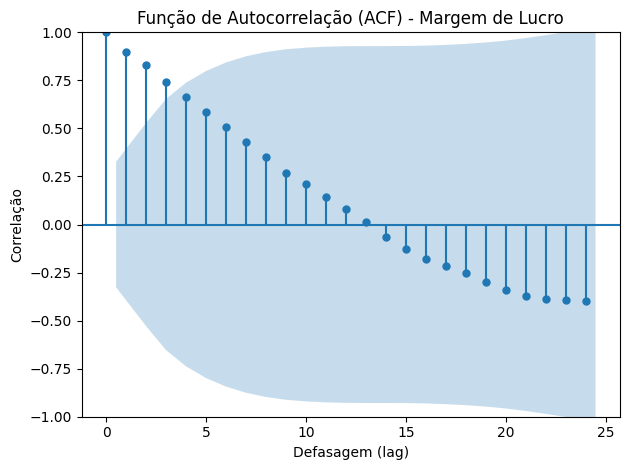

In [7]:
#Plotar a função de autocorrelação
serie = serie.dropna()
plt.figure(figsize=(10, 4))
plot_acf(serie, lags=24, alpha=0.05)  # até 24 defasagens (meses)
plt.title("Função de Autocorrelação (ACF) - Margem de Lucro")
plt.xlabel("Defasagem (lag)")
plt.ylabel("Correlação")
plt.tight_layout()
plt.show()

<Figure size 1000x400 with 0 Axes>

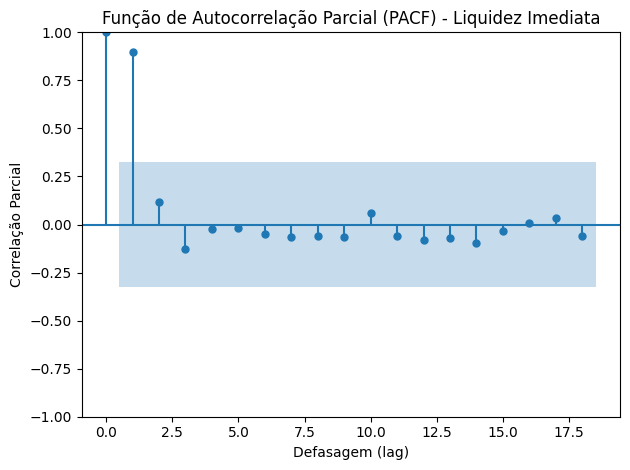

In [8]:
plt.figure(figsize=(10, 4))
plot_pacf(serie, lags=18, alpha=0.05, method='ywm')
plt.title("Função de Autocorrelação Parcial (PACF) - Liquidez Imediata")
plt.xlabel("Defasagem (lag)")
plt.ylabel("Correlação Parcial")
plt.tight_layout()
plt.show()

In [29]:
previsao_futura = forecast_future_periods(
    indicadores_historicos, target_col='Liquidez_Imediata', horizon=6)

previsao_futura

21:59:46 - cmdstanpy - INFO - Chain [1] start processing
21:59:46 - cmdstanpy - INFO - Chain [1] done processing


✅ Previsão futura concluída com sucesso!


,ds,forecast
0,2025-01-01,0.420741
1,2025-02-01,0.625147
2,2025-03-01,0.820994
3,2025-04-01,0.932121
4,2025-05-01,0.850834
5,2025-06-01,0.705411


In [ ]:
m = Prophet(yearly_seasonality=True,
            monthly_seasonality=False, daily_seasonality=False)
m.fit(indicadores_historicos["Lucro_Líquido"])

# Gerar previsões para 12 meses à frente
future = m.make_future_dataframe(periods=12, freq='M')
forecast = m.predict(future)

# Visualizar
m.plot(forecast)
m.plot_components(forecast)

TypeError: __init__() got an unexpected keyword argument 'monthly_seasonality'